In [1]:
from __future__ import division
from utils import *
from functions import *
from numba import autojit
%matplotlib inline

%load_ext autoreload
%autoreload 2

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000 - PhD/figures/"+todayStr+"/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)

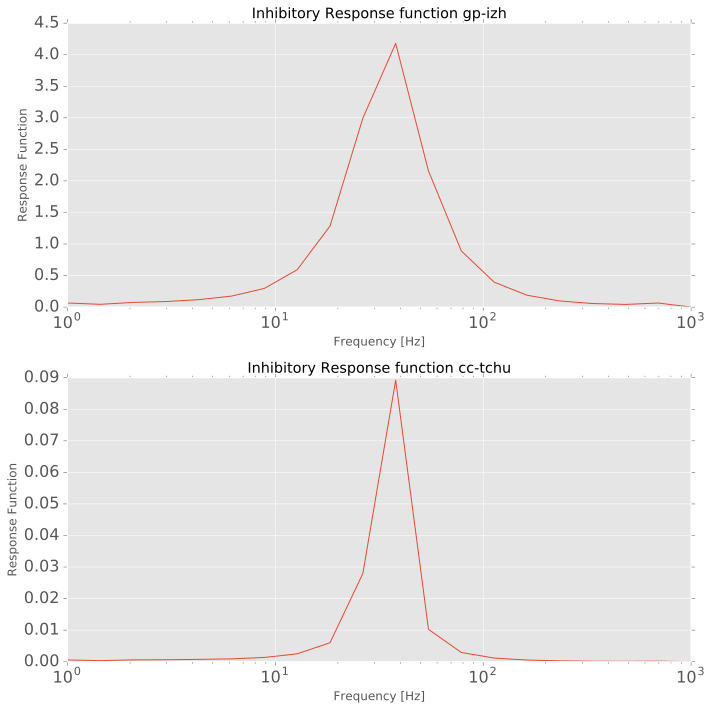

In [51]:
'''
SINGLE NEURON FREQUENCY RESPONSE
'''
T = 2000
dt = 1
t = np.arange(0,T,dt)
F = np.logspace(0,3,20)

@autojit
def resonance(F, model = 'cc'):
    res_var = np.empty(len(F), dtype=np.float64)
    b = 2
    for k,f in enumerate(F):
        A = 0.1
        I = A*np.cos(2*np.pi*f*t/1000)
        res_v = []
        res_u = []
        u=0
        if model == 'izh':
            v = -65
            for i in range(len(t)):
                v += dt/20 * ( (v+60)*(v+50) - 20000*u + 30*I[i])
                u += dt * 0.2 * ( 0.025 * (v +55)**3*(v>-55) - u)
                if v>25:
                    v = -45
                if i*dt>1500:
                    res_v.append(v/A)
        elif model == 'gp-izh':
            v = -60
            for i in range(len(t)):
                v += dt/15 * ( (v+60)*(v+50) - 20*u + 8*I[i])
                u += dt * 0.03 * ( (v +55) - u)
                if v>25:
                    v = -40
                    u += 50
                if i*dt>1500:
                    res_v.append(v/A)
        elif model == 'cc-tchu': 
            v = -65
            u = 0
            for i in range(len(t)):
                v += dt/100 * ( -v + -20*u + 30*I[i] );     
                u += dt/20 * ( -u + 4.5*v );
                if i*dt>1500:
                    res_v.append(v)
        elif model == 'TRN':
            v = -60
            for i in range(len(t)):
                v += dt/40 * ( 0.25*(v**2 + 110*v +45*65) - 2000*u + 0.01*I[i])
                u += dt * 0.015 * (b* (v +65) - u)
                if v>0:
                    v = -55
                    u += 50
                b = 10 * (v<-70) + 2*(v>=70)
                if i*dt>1500:
                    res_v.append(v/A)
            
        var = np.var(res_v)
#         var = np.max(res_v)-np.min(res_v)
        res_var[k] = var
    return res_var
# models = ['TRN','cc-izh', 'izh', 'mod1', 'cc-tchu']
models = ['gp-izh', 'cc-tchu']
# models = ['cc-tchu']
c = 0
fig = plt.figure(figsize=(10,10))
for model in models:
    c+=1
    ax = fig.add_subplot(210+c)
    ax.semilogx(F, resonance(F, model))
    ax.set_title('Inhibitory Response function '+model)
    ax.set_ylabel('Response Function')
    ax.set_xlabel('Frequency [Hz]')
plt.tight_layout()
plt.savefig(DIRECTORY + model +'_.pdf')

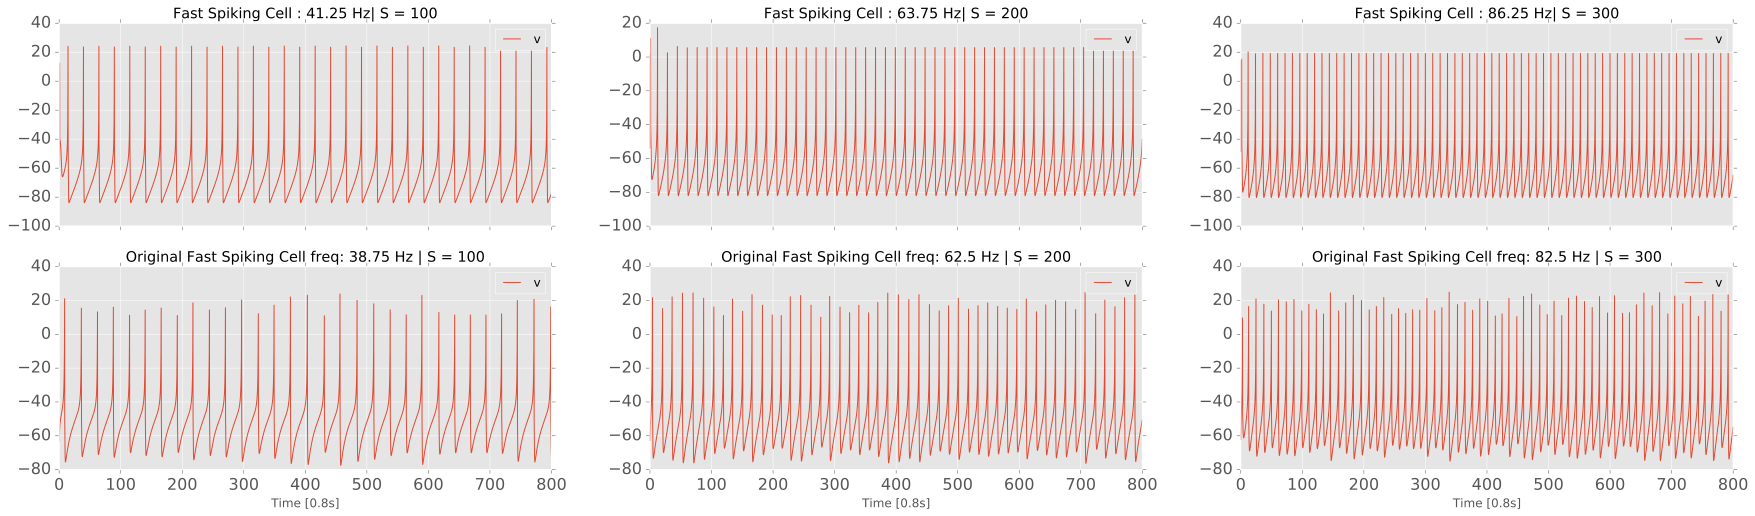

In [45]:
T = 800
dt = 0.1
t = np.arange(0,T,dt)
v = -65

fig = plt.figure(figsize=(30,8))

for i,s in enumerate([100,200,300]):
    ax = fig.add_subplot(231+i) 
    res_v = []
    res_u = []
    I = s
    c= 0
    u=0
    v = -65
    for i in t:
        v += dt/15 * ( (v+60)*(v+50) - 20*u + 8*I)
        u += dt * 0.03 * ( (v +55) - u)
        if v>25:
            v = -40
            u += 50
            c+=1
        res_v.append(v)
        res_u.append(u)
    ax.set_xticklabels([])
    ax.plot(t, res_v, label='v')
#     ax.plot(t, res_u, label='u')
    ax.legend()
    ax.set_title('Fast Spiking Cell : %g Hz| S = %d'%(float(1000*c/T),s))
    # plt.plot(t, res_u, label = 'u')

for i,s in enumerate([100,200,300]):
    ax = fig.add_subplot(234+i) 
    res_v = []
    res_u = []
    c = 0
    I = s
    u=0
    v = -65
    for i in t:
        v += dt/20 * ( (v+55)*(v+40) - u + I)
        u += dt * 0.2 * ( 0.025 * (v +55)**3*(v>-55) - u)
        if v>25:
            c += 1
            v = -45
        res_v.append(v)
        res_u.append(u)
    ax.set_xlabel('Time [0.8s]')
    ax.plot(t, res_v, label='v')
#     ax.plot(t, res_u, label='u')
    ax.legend()
    ax.set_title('Original Fast Spiking Cell freq: %g Hz | S = %d'%(float(1000*c/T),s))


plt.savefig(DIRECTORY + 'neuron_models.pdf')
